# Analysis of Longitudinal Change in PVC vc Non-PVC Data

In [64]:
using Pkg
Pkg.status()

Status `~/Projects/local-fkpp/Project.toml`
  [3276ce4d] ADNIDatasets v0.1.0 `https://github.com/PavanChaggar/ADNIDatasets.jl.git#main`
  [0bf59076] AdvancedHMC v0.6.4
  [6e4b80f9] BenchmarkTools v1.6.0
  [336ed68f] CSV v0.10.15
  [55f7864d] Connectomes v0.1.0 `https://github.com/PavanChaggar/Connectomes.jl.git#main`
  [a93c6f00] DataFrames v1.7.0
  [0c46a032] DifferentialEquations v7.16.0
  [31c24e10] Distributions v0.25.117
  [634d3b9d] DrWatson v2.18.0
  [38e38edf] GLM v1.9.0
⌃ [e9467ef8] GLMakie v0.10.18
  [86223c79] Graphs v1.12.0
  [09f84164] HypothesisTests v0.11.3
  [7073ff75] IJulia v1.26.0
  [6fdf6af0] LogDensityProblems v2.1.2
  [996a588d] LogDensityProblemsAD v1.13.0
  [c7f686f2] MCMCChains v6.0.7
  [429524aa] Optim v1.11.0
  [1dea7af3] OrdinaryDiffEq v6.91.0
  [43a3c2be] PairPlots v3.0.1
  [b1d3bc72] Pathfinder v0.9.9
  [91a5bcdd] Plots v1.40.9
  [08abe8d2] PrettyTables v2.4.0
  [1ed8b502] SciMLSensitivity v7.74.0
  [f3b207a7] StatsPlots v0.15.7
⌃ [337ecbd1] TidierPlots v0

In [65]:
using ADNIDatasets
using Connectomes
using CSV, DataFrames
using DrWatson
using CairoMakie
include(projectdir("functions.jl"))

regional_mean (generic function with 2 methods)

In [66]:
# Convenience functions for calculating longitudinal changes
function get_diff(x::Matrix{Float64})
    x[:,end] .- x[:,1]
end
function get_diff(x::Vector{Float64})
    x[end] - x[1]
end
cols = Makie.wong_colors();

## Analysis without PVC

In [95]:
include(projectdir("adni/inference/inference-preamble.jl")); # Load data
_abneg_data = ADNIDataset(negdf, dktnames; min_scans=3, reference_region="INFERIORCEREBELLUM", qc=true)
n_subjects = length(_abneg_data)

66

In [96]:
abneg_mtl_pos = filter(x -> regional_mean(_abneg_data, mtl, x) >= mtl_cutoff, 1:n_subjects)
abneg_neo_pos = filter(x -> regional_mean(_abneg_data, neo, x) >= neo_cutoff, 1:n_subjects)

abneg_tau_pos = findall(x -> x ∈ unique([abneg_mtl_pos; abneg_neo_pos]), 1:n_subjects)
abneg_tau_neg = findall(x -> x ∉ abneg_tau_pos, 1:n_subjects)

abneg_data = _abneg_data[abneg_tau_neg]


ADNI data set with 60 subjects and 204 scans.

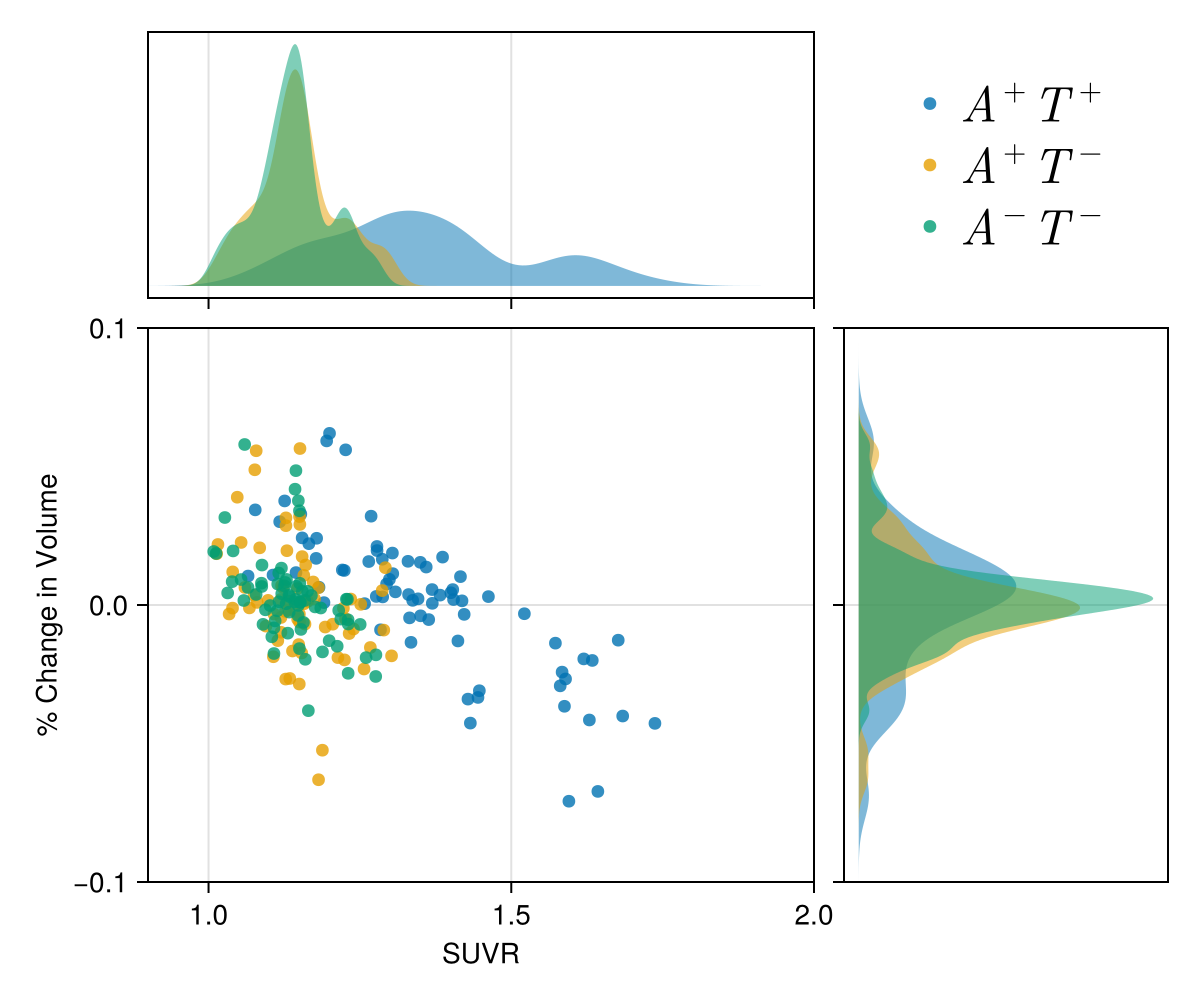

In [69]:
begin

    f = Figure(size=(600, 500))
    ax1 = Axis(f[2:3,1:2], xlabel="SUVR", ylabel="% Change in Volume")
    ylims!(ax1, -0.1, 0.1)
    xlims!(ax1, 0.9, 2.)

    ax2 = Axis(f[1,1:2])
    xlims!(ax2, 0.9, 2.)

    hidexdecorations!(ax2, ticks=false, grid=false)
    hideydecorations!(ax2, )

    ax3 = Axis(f[2:3,3])
    ylims!(ax3, -0.1, 0.1)
    hideydecorations!(ax3, ticks=false, grid=false)
    hidexdecorations!(ax3, )

    for (i, (d, label)) in enumerate(zip([pos_data, neg_data, abneg_data], [L"A^+T^+",L"A^+T^-",L"A^-T^-"]))

        subsuvr = calc_suvr.(d)
        subdata = [normalise(sd, u0, cc) for sd in subsuvr]

        # calculate volume data
        _vols = get_vol.(d)
        total_vol_norm = [tp ./ sum(tp, dims=1) for tp in _vols]
        vols = [(vol ./ vol[:,1]) for vol in total_vol_norm];

        scatter!(ax1, vec(mean(reduce(hcat, subdata), dims=2)), vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), color=(cols[i], 0.8),label=label)
        
        density!(ax2, vec(mean(reduce(hcat, subdata), dims=2)), color=(cols[i], 0.5))

        density!(ax3, vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), direction=:y, color=(cols[i], 0.5))
    end
    leg = Legend(f[1, 3], ax1, framevisible=false, tellwidth=false, labelsize=25)

    rowgap!(f.layout, 10)
    colgap!(f.layout, 10)
    f
end

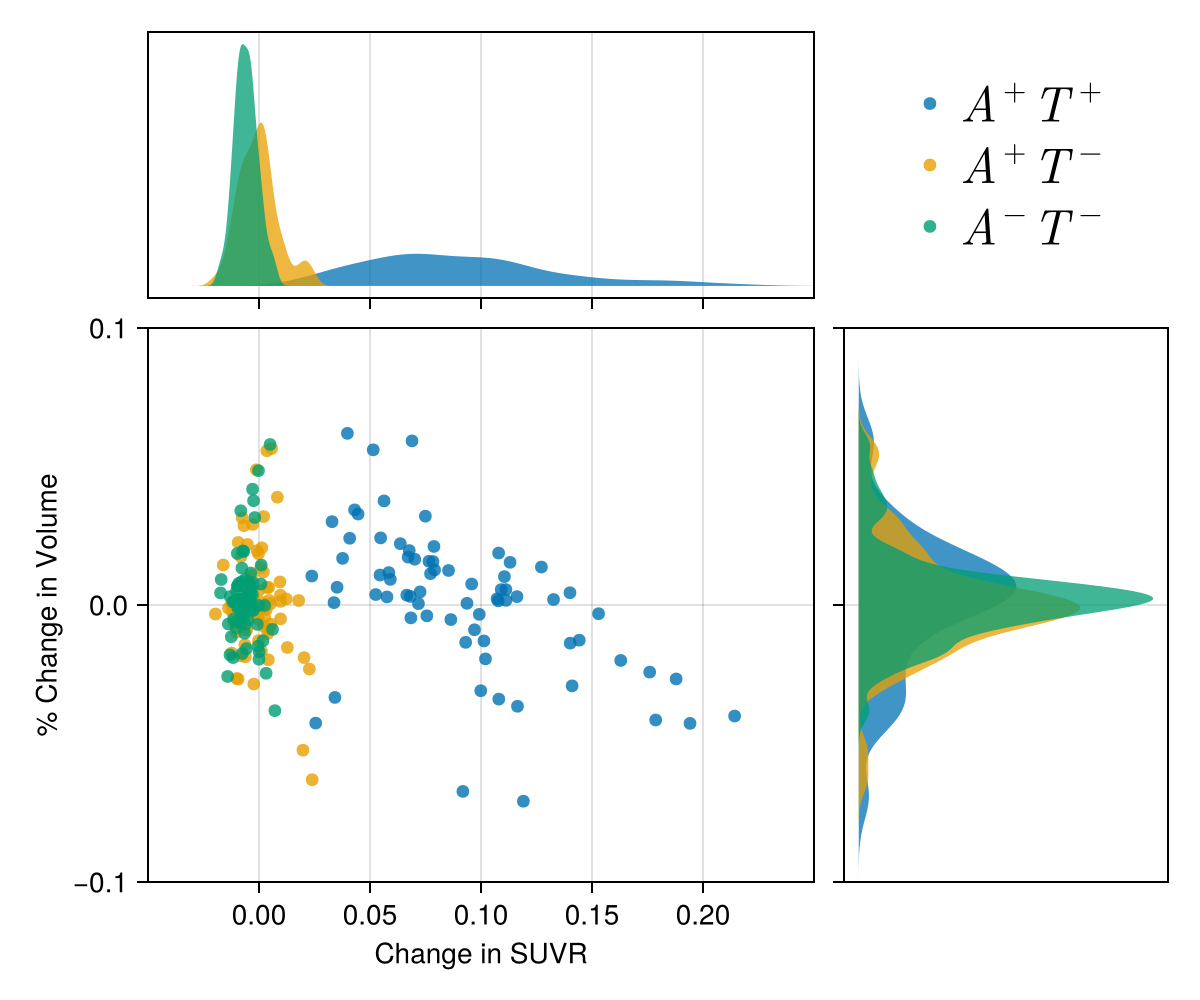

In [70]:
begin

    f = Figure(size=(600, 500))
    ax1 = Axis(f[2:3,1:2], xlabel="Change in SUVR", ylabel="% Change in Volume")
    ylims!(ax1, -0.1, 0.1)
    xlims!(ax1, -0.05, 0.25)

    ax2 = Axis(f[1,1:2])
    xlims!(ax2, -0.05, 0.25)
    hidexdecorations!(ax2, ticks=false, grid=false)
    hideydecorations!(ax2, )

    ax3 = Axis(f[2:3,3])
    ylims!(ax3, -0.1, 0.1)
    hideydecorations!(ax3, ticks=false, grid=false)
    hidexdecorations!(ax3, )

    for (i, (d, label)) in enumerate(zip([pos_data, neg_data, abneg_data], [L"A^+T^+",L"A^+T^-",L"A^-T^-"]))

        subsuvr = calc_suvr.(d)
        subdata = [normalise(sd, u0, cc) for sd in subsuvr]

        # calculate volume data
        _vols = get_vol.(d)
        total_vol_norm = [tp ./ sum(tp, dims=1) for tp in _vols]
        vols = [(vol ./ vol[:,1]) for vol in total_vol_norm];

        scatter!(ax1, vec(mean(reduce(hcat, get_diff.(subdata)), dims=2)), vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), color=(cols[i], 0.8), label=label)
        
        density!(ax2, vec(mean(reduce(hcat, get_diff.(subdata)), dims=2)), color=(cols[i], 0.75))

        density!(ax3, vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), direction=:y, color=(cols[i], 0.75))
    end
    leg = Legend(f[1, 3], ax1, framevisible=false, tellwidth=false, labelsize=25)
    rowgap!(f.layout, 10)
    colgap!(f.layout, 10)
    f
end

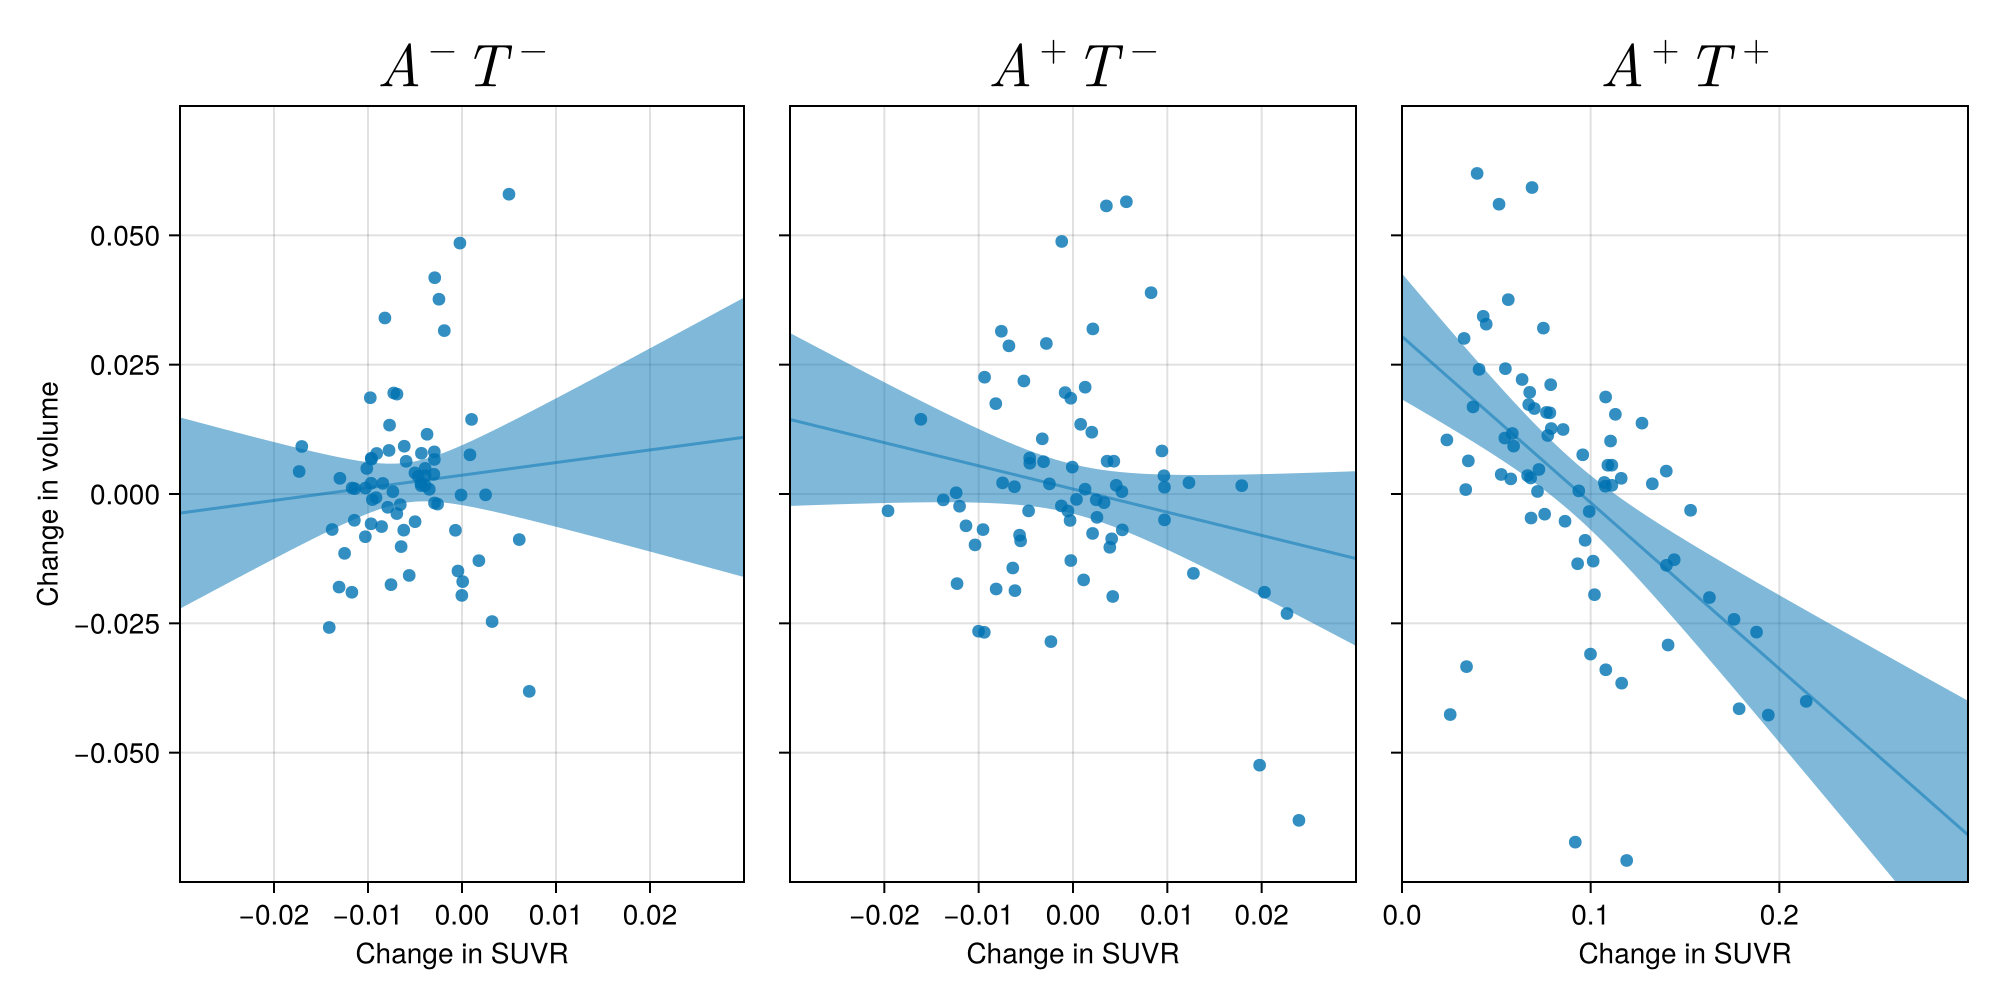

In [71]:
using GLM 

f = Figure(size=(1000, 500))


for (i, (d, label, lim)) in enumerate(zip(reverse([pos_data, neg_data, abneg_data]), 
                                          reverse([L"A^+T^+",L"A^+T^-",L"A^-T^-"]), 
                                          [[-0.03, 0.03], [-0.03, 0.03], [0.0, 0.3]]))
    
    ax = Axis(f[1,i], title=label, titlesize=30, ylabel="Change in volume", xlabel="Change in SUVR", yticks=-0.05:0.025:0.05)
    ylims!(ax, -0.075, 0.075)
    xlims!(ax, lim[1], lim[2])
    if i > 1
        hideydecorations!(ax, grid=false, ticks=false)
    end
    subsuvr = calc_suvr.(d)
    subdata = [normalise(sd, u0, cc) for sd in subsuvr]

    _vols = get_vol.(d)
    total_vol_norm = [tp ./ sum(tp, dims=1) for tp in _vols]
    vols = [(vol ./ vol[:,1]) for vol in total_vol_norm];

    df = DataFrame(d = vec(mean(reduce(hcat, get_diff.(subdata)), dims=2)), v = vec(mean(reduce(hcat, get_diff.(vols)), dims=2)))

    ols = lm(@formula(v ~ d), df)
    pred = predict(ols, df)

    tdf = DataFrame(d = lim[1]:0.001:lim[2])
    pred = predict(ols, tdf, interval = :confidence, level = 0.95) |> dropmissing

    # f = scatter(vec(mean(reduce(hcat, get_diff.(subdata)), dims=2)), vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), color=(cols[3], 0.8),)
    scatter!(ax, df.d, df.v, color=(cols[1], 0.8),)
    lines!(ax, tdf.d, pred.prediction, color=(cols[1], 0.5))
    band!(ax, tdf.d, pred.lower, pred.upper, color=(cols[1], 0.5))
end
f

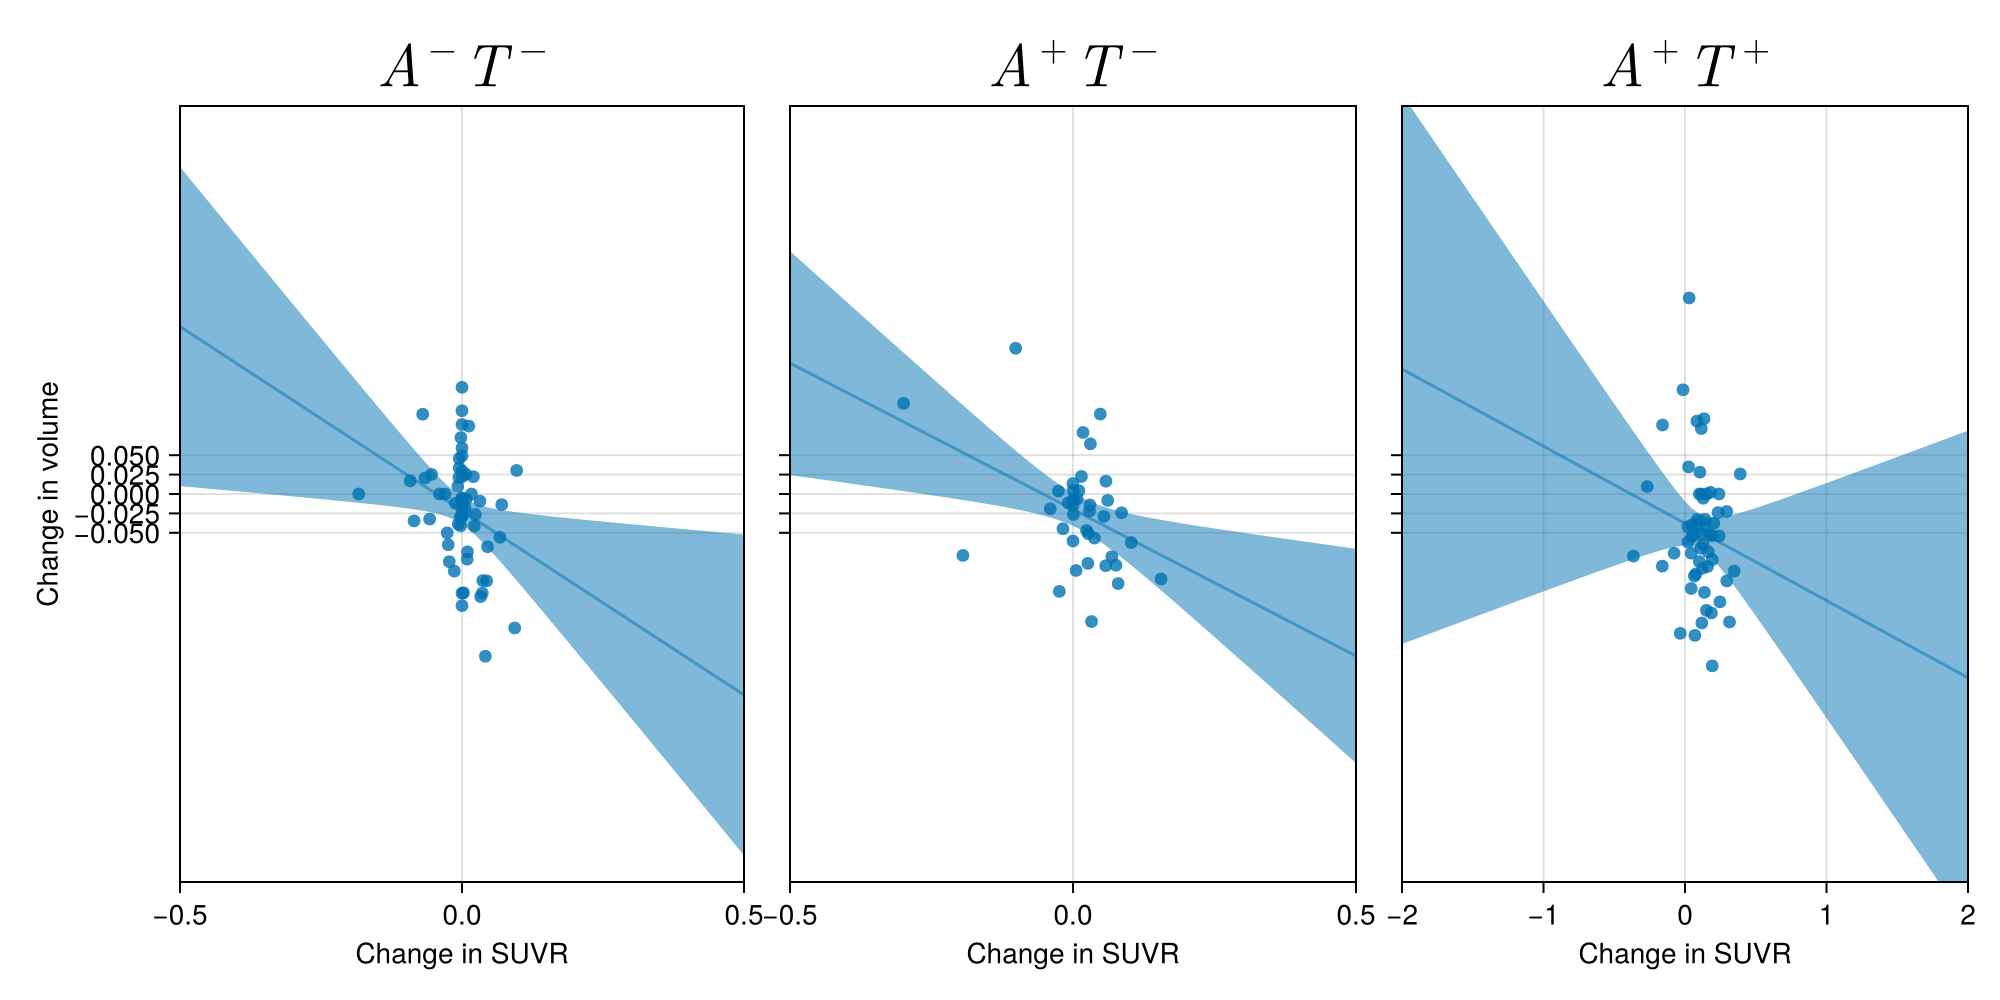

In [72]:
using GLM 

f = Figure(size=(1000, 500))


for (i, (d, label, lim)) in enumerate(zip(reverse([pos_data, neg_data, abneg_data]), 
                                          reverse([L"A^+T^+",L"A^+T^-",L"A^-T^-"]), 
                                          [[-0.5, 0.5], [-0.5, 0.5], [-2, 2]]))
    
    ax = Axis(f[1,i], title=label, titlesize=30, ylabel="Change in volume", xlabel="Change in SUVR", yticks=-0.05:0.025:0.05)
    ylims!(ax, -0.5, 0.5)
    xlims!(ax, lim[1], lim[2])
    if i > 1
        hideydecorations!(ax, grid=false, ticks=false)
    end
    subsuvr = calc_suvr.(d)
    subdata = [normalise(sd, u0, cc) for sd in subsuvr]

    _vols = get_vol.(d)
    total_vol_norm = [tp ./ sum(tp, dims=1) for tp in _vols]
    vols = [(vol ./ vol[:,1]) for vol in total_vol_norm];

    df = DataFrame(d = vec(mean(reduce(hcat, get_diff.(subdata))[mtl, :], dims=1)), v = vec(mean(reduce(hcat, get_diff.(vols))[mtl, :], dims=1)))

    ols = lm(@formula(v ~ d), df)
    pred = predict(ols, df)

    tdf = DataFrame(d = lim[1]:0.001:lim[2])
    pred = predict(ols, tdf, interval = :confidence, level = 0.95) |> dropmissing

    # f = scatter(vec(mean(reduce(hcat, get_diff.(subdata)), dims=2)), vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), color=(cols[3], 0.8),)
    scatter!(ax, df.d, df.v, color=(cols[1], 0.8),)
    lines!(ax, tdf.d, pred.prediction, color=(cols[1], 0.5))
    band!(ax, tdf.d, pred.lower, pred.upper, color=(cols[1], 0.5))
end
f

In [123]:
sum(_vols[1], dims=1)

1×3 Matrix{Float64}:
 395135.0  395735.0  397066.0

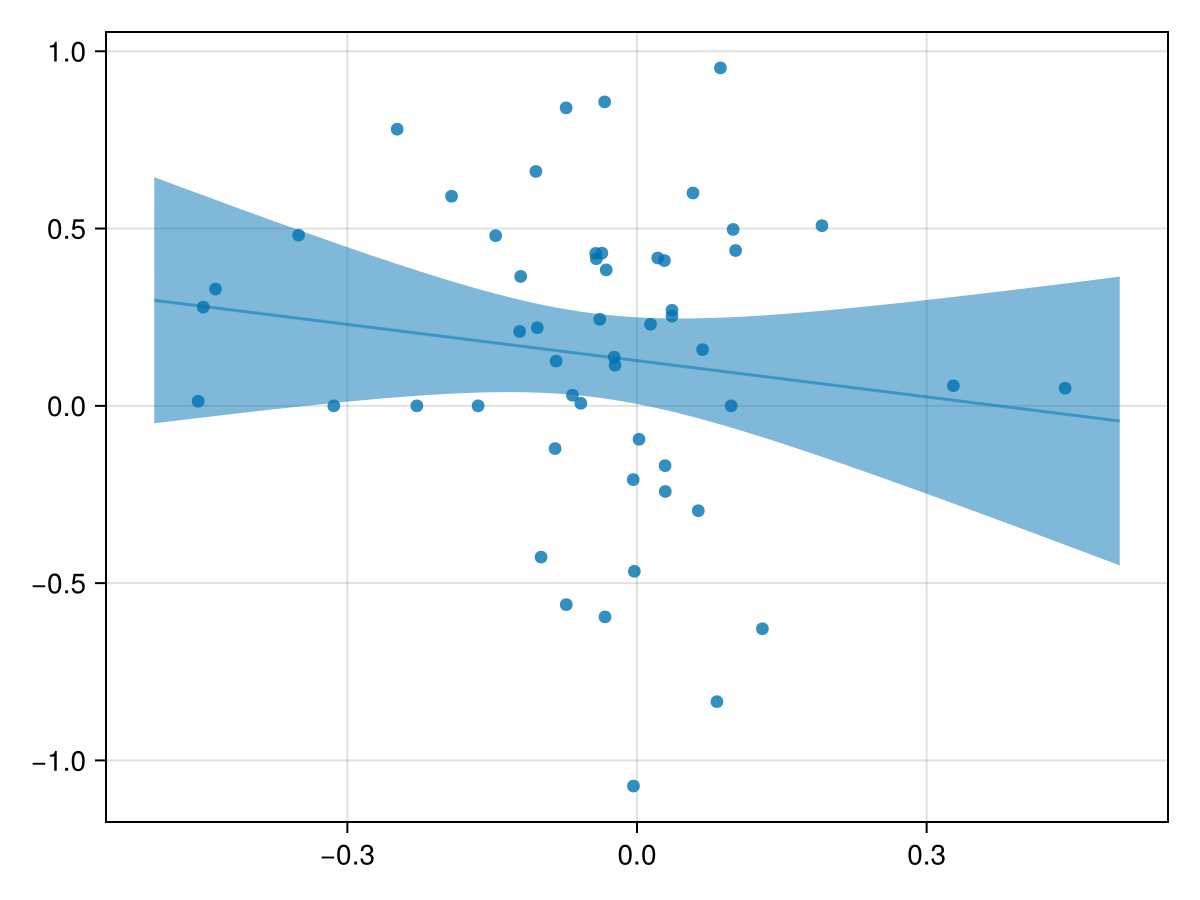

In [127]:
using Turing 
using Serialization

pst = deserialize(projectdir("adni/new-chains/local-fkpp/length-free/pst-abneg-4x2000.jls"));
meanpst = mean(pst);

as = [meanpst["α[$i]", :mean] for i in 1:53]

subsuvr = calc_suvr.(abneg_data)
_subdata = [normalise(sd, u0, cc) for sd in subsuvr]
blsd = [sd .- u0 for sd in _subdata]
nonzerosubs = findall(x -> sum(x) < 2, [sum(sd, dims=1) .== 0 for sd in blsd])
subdata = _subdata[nonzerosubs]

_vols = get_vol.(abneg_data[nonzerosubs])
total_vol_norm = [tp ./ sum(tp, dims=1) for tp in _vols]
vols = [(vol ./ vol[:,1]) for vol in total_vol_norm];

df = DataFrame(d = as, v = vec(sum(reduce(hcat, get_diff.(vols)), dims=1)))

ols = lm(@formula(v ~ d), df)
pred = predict(ols, df)

tdf = DataFrame(d = -0.5:0.001:0.5)
pred = predict(ols, tdf, interval = :confidence, level = 0.95) |> dropmissing

# f = scatter(vec(mean(reduce(hcat, get_diff.(subdata)), dims=2)), vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), color=(cols[3], 0.8),)
f = scatter(df.d, df.v, color=(cols[1], 0.8),)
lines!(tdf.d, pred.prediction, color=(cols[1], 0.5))
band!(tdf.d, pred.lower, pred.upper, color=(cols[1], 0.5))
f

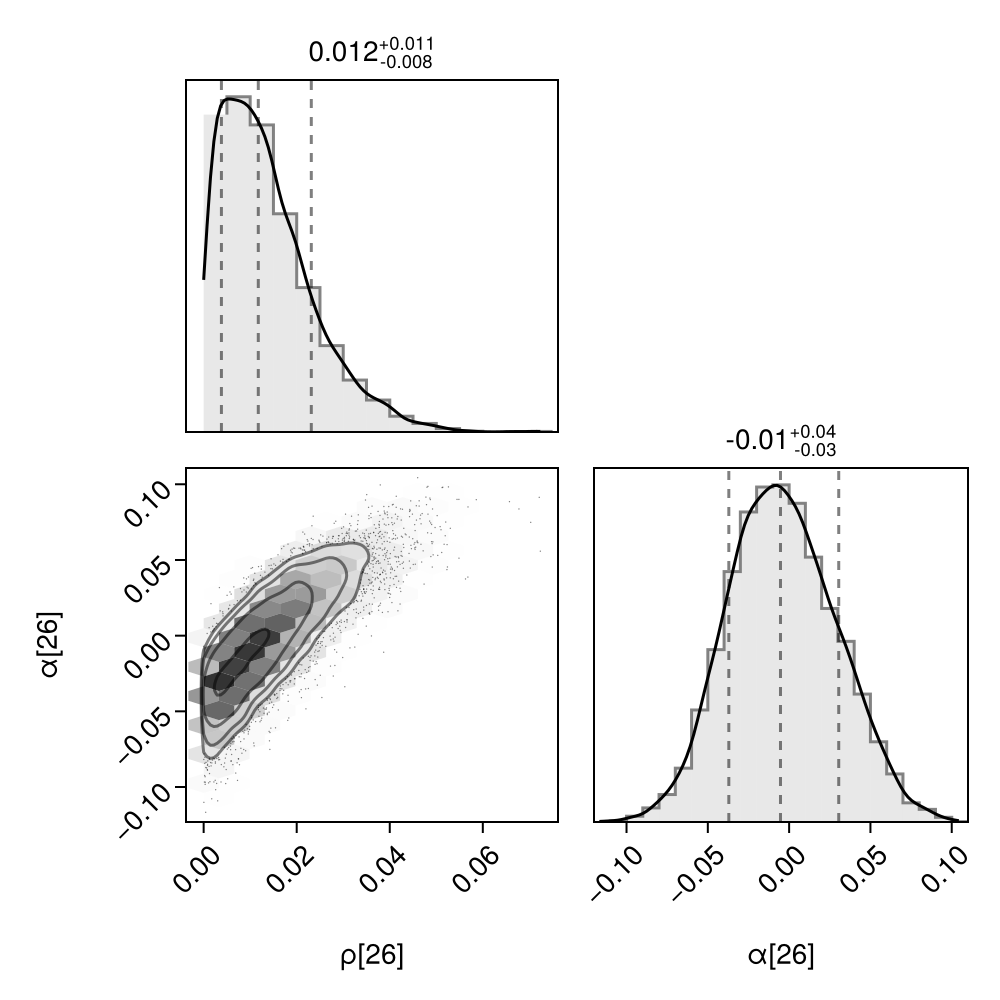

In [ ]:
using PairPlots
pst = deserialize(projectdir("adni/new-chains/local-fkpp/length-free/pst-abneg-4x2000.jls"));

begin
    f = Figure(size=(500, 500))
    ax = GridLayout(f[1,1])
    sub = 26
    pairplot(ax, pst[["α[$sub]", "ρ[$sub]"]])

end
f


## Analysis with PVC

In [73]:
include(projectdir("adni/inference/local-fkpp/pvc/inference-preamble-pvc.jl"))

_abneg_data = ADNIDataset(negdf, dktnames; min_scans=3, reference_region="INFERIORCEREBELLUM", qc=true)
n_subjects = length(_abneg_data)

64

In [74]:
mtl_cutoff_pvc = mean(gmm_moments.cutoff[mtl])
neo_cutoff_pvc = mean(gmm_moments.cutoff[neo])

abneg_mtl_pos = filter(x -> regional_mean(_abneg_data, mtl, x) >= mtl_cutoff_pvc, 1:n_subjects)
abneg_neo_pos = filter(x -> regional_mean(_abneg_data, neo, x) >= neo_cutoff_pvc, 1:n_subjects)

abneg_tau_pos = findall(x -> x ∈ unique([abneg_mtl_pos; abneg_neo_pos]), 1:n_subjects)
abneg_tau_neg = findall(x -> x ∉ abneg_tau_pos, 1:n_subjects)

abneg_data = _abneg_data[abneg_tau_neg]

ADNI data set with 61 subjects and 208 scans.

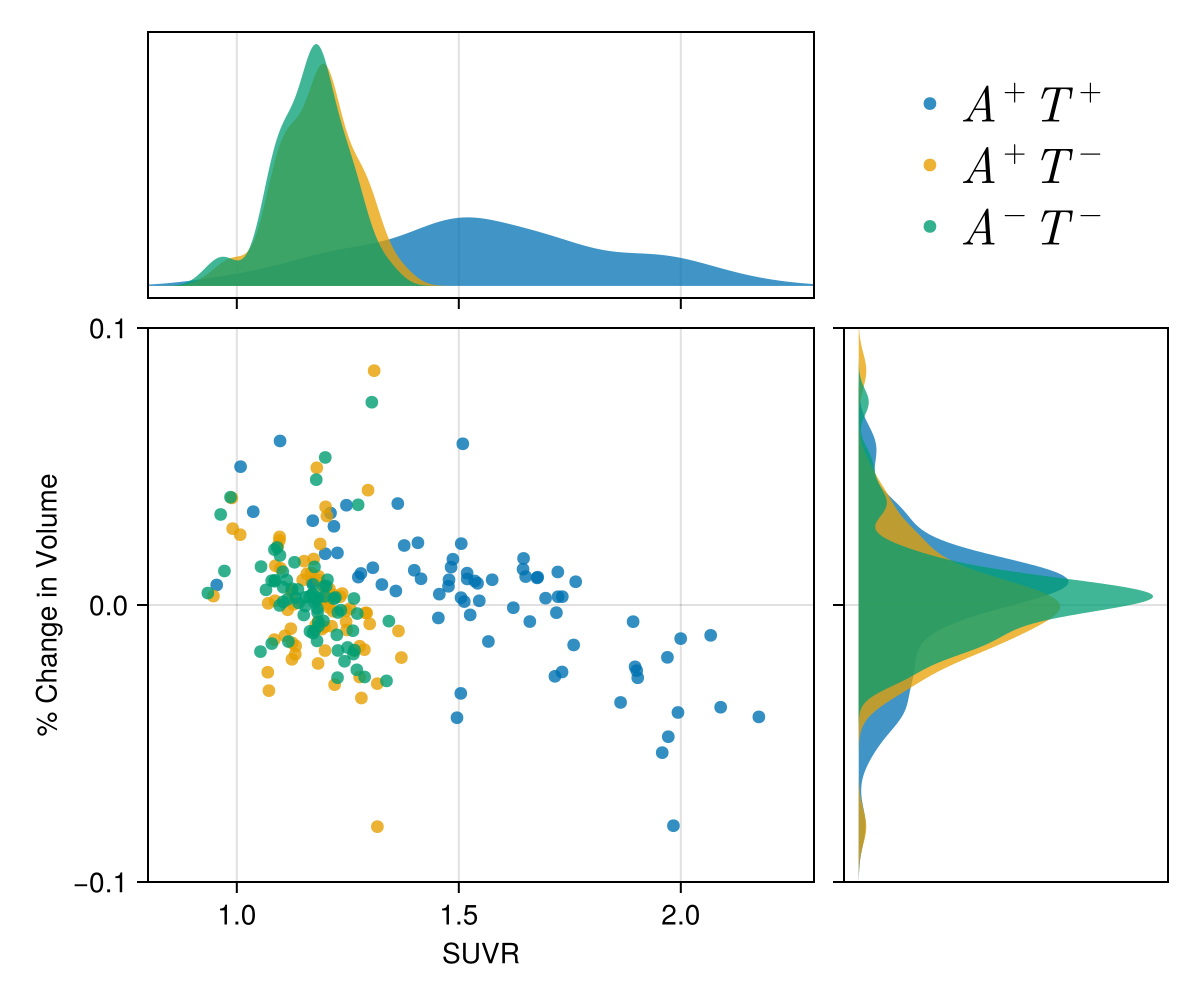

In [75]:
begin

    f = Figure(size=(600, 500))
    ax1 = Axis(f[2:3,1:2], xlabel="SUVR", ylabel="% Change in Volume")
    ylims!(ax1, -0.1, 0.1)
    xlims!(ax1, 0.8, 2.3)

    ax2 = Axis(f[1,1:2])
    xlims!(ax2, 0.8, 2.3)

    hidexdecorations!(ax2, ticks=false, grid=false)
    hideydecorations!(ax2, )

    ax3 = Axis(f[2:3,3])
    ylims!(ax3, -0.1, 0.1)
    hideydecorations!(ax3, ticks=false, grid=false)
    hidexdecorations!(ax3, )

    for (i, (d, label)) in enumerate(zip([pos_data, neg_data, abneg_data], [L"A^+T^+",L"A^+T^-",L"A^-T^-"]))

        subsuvr = calc_suvr.(d)
        subdata = [normalise(sd, u0, cc) for sd in subsuvr]

        # calculate volume data
        _vols = get_vol.(d)
        total_vol_norm = [tp ./ sum(tp, dims=1) for tp in _vols]
        vols = [(vol ./ vol[:,1]) for vol in total_vol_norm];

        scatter!(ax1, vec(mean(reduce(hcat, subdata), dims=2)), vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), color=(cols[i], 0.8),label=label)
        
        density!(ax2, vec(mean(reduce(hcat, subdata), dims=2)), color=(cols[i], 0.75))

        density!(ax3, vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), direction=:y, color=(cols[i], 0.75))
    end
    leg = Legend(f[1, 3], ax1, framevisible=false, tellwidth=false, labelsize=25)

    rowgap!(f.layout, 10)
    colgap!(f.layout, 10)
    f
end

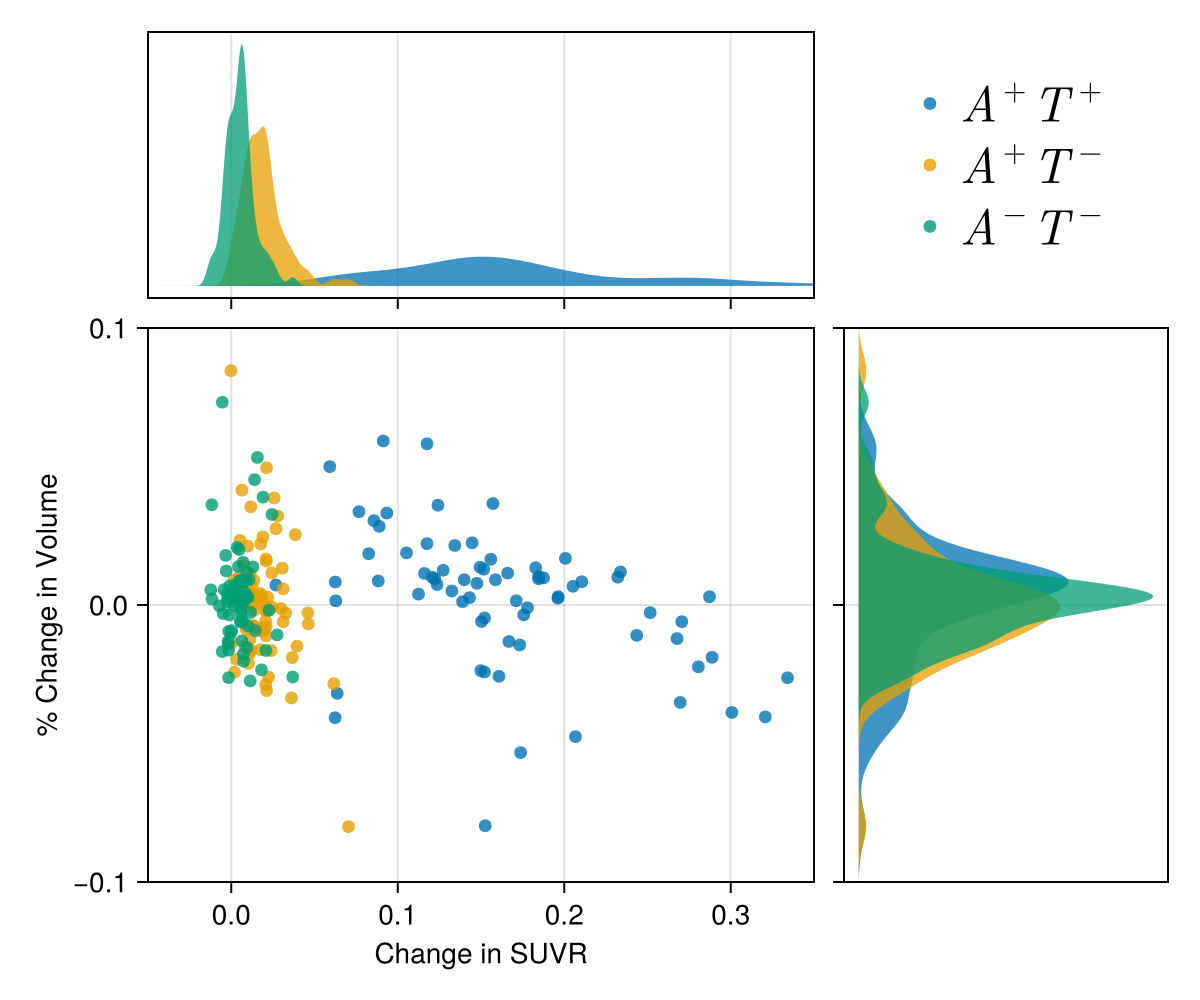

In [76]:
begin

    f = Figure(size=(600, 500))
    ax1 = Axis(f[2:3,1:2], xlabel="Change in SUVR", ylabel="% Change in Volume")
    ylims!(ax1, -0.1, 0.1)
    xlims!(ax1, -0.05, 0.35)

    ax2 = Axis(f[1,1:2])
    xlims!(ax2, -0.05, 0.35)
    hidexdecorations!(ax2, ticks=false, grid=false)
    hideydecorations!(ax2, )

    ax3 = Axis(f[2:3,3])
    ylims!(ax3, -0.1, 0.1)
    hideydecorations!(ax3, ticks=false, grid=false)
    hidexdecorations!(ax3, )

    for (i, (d, label)) in enumerate(zip([pos_data, neg_data, abneg_data], [L"A^+T^+",L"A^+T^-",L"A^-T^-"]))

        subsuvr = calc_suvr.(d)
        subdata = [normalise(sd, u0, cc) for sd in subsuvr]

        # calculate volume data
        _vols = get_vol.(d)
        total_vol_norm = [tp ./ sum(tp, dims=1) for tp in _vols]
        vols = [(vol ./ vol[:,1]) for vol in total_vol_norm];

        scatter!(ax1, vec(mean(reduce(hcat, get_diff.(subdata)), dims=2)), vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), color=(cols[i], 0.8), label=label)
        
        density!(ax2, vec(mean(reduce(hcat, get_diff.(subdata)), dims=2)), color=(cols[i], 0.75))

        density!(ax3, vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), direction=:y, color=(cols[i], 0.75))
    end
    leg = Legend(f[1, 3], ax1, framevisible=false, tellwidth=false, labelsize=25)
    rowgap!(f.layout, 10)
    colgap!(f.layout, 10)
    f
end